# Assignment 2: CRF sequence tagging for Move Queries

In [33]:
#libraries imported
import os
import sys
import pandas as pd
from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [34]:
#installing python-crfsuite 
!pip install nltk python-crfsuite scikit-learn
import pycrfsuite

In [35]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [36]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [37]:
# have a look at the first example
print(raw_training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [38]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

9775 instances
99491 words


In [39]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.

In [40]:
testData = []
trainData = []
def splitData(percentage):
    # A method to split the data between trainData and testData 
    dataSamples = len(raw_training_data)
    #to find half of data
    halfOfData = int(len(raw_training_data)/2)
    #finding training samples
    trainingSamples = int((percentage*dataSamples)/2)
    #splitting of trainData
    for (Text) in raw_training_data[:trainingSamples] + raw_training_data[halfOfData:halfOfData+trainingSamples]:
        trainData.append(Text)
    #splitting of testData
    for (Text) in raw_training_data[trainingSamples:halfOfData] + raw_training_data[halfOfData+trainingSamples:]:
        testData.append(Text)
#80% of trainData and 20% of testData
splitData(0.8)
#print the size of trainData and testData
print(len(trainData), len(testData))

7820 1955


In [41]:
training_data = [preProcess(example) for example in raw_training_data]

In [42]:
# check the effect of pre-processing
print(training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [43]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [44]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")
test_data = testData

training tagger...
done


In [45]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [46]:
print("testing tagger...")
preds = []
y_test = []

for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")           


testing tagger...
done


In [47]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.76      0.88      0.81       812
      B-CHARACTER       0.72      0.26      0.38        90
       B-DIRECTOR       0.78      0.61      0.69       456
          B-GENRE       0.91      0.95      0.93      1117
           B-PLOT       0.60      0.40      0.48       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.87      0.82      0.84       451
         B-REVIEW       0.14      0.02      0.03        56
           B-SONG       0.69      0.17      0.27        54
          B-TITLE       0.58      0.50      0.54       562
        B-TRAILER       0.80      0.80      0.80        30
           B-YEAR       0.94      0.94      0.94       720
          I-ACTOR       0.75      0.89      0.81       862
      I-CHARACTER       0.76      0.29      0.42        75
       I-DIRECTOR       0.78      0.60      0.68       496
          I-GENRE       0.84      0.71      0.77       

# 2. Error analysis 1: False positives (10 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.

In [48]:
# Output the classification report (which you should save each time for comparing your models)
report=classification_report(y_test, preds, output_dict=True)

#creating a list(localdict)
c=[]

#creating a loop for report yo find the least 5 precision
for i,j in report.items():
  
    #accuracy, macro avg and weighted avg is popped out
    if ((i!='accuracy') and (i!='macro avg') and (i!='weighted avg')):
        for a,b in j.items():
            #precision is finded and append it in the list
            if(a=='precision'):
                c.append((i,a,b))

#using pandas dataframe first 3 columns are displayed
df=pd.DataFrame(c,columns=['col1','col2','col3'])
#sorting is done to find the least precisions
df_sort=df.sort_values('col3',ascending=True)
#displaying the columns
df_sort.head()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,col1,col2,col3
22,I-TRAILER,precision,0.000000
19,I-REVIEW,precision,0.000000
7,B-REVIEW,precision,0.142857
16,I-PLOT,precision,0.490854
9,B-TITLE,precision,0.578732


In [49]:
#lowest 5 precision is ordered and stored in a list
precision= list(df_sort['col1'].head())
display(precision)

['I-TRAILER', 'I-REVIEW', 'B-REVIEW', 'I-PLOT', 'B-TITLE']

In [50]:
#ERROR ANALYSIS 1 - FALSE POSITIVES

#printing a testing tagger
print("testing tagger...")
print('False_positives:')
#prediction list
preds = []
#test list
y_test = []

#creating loop to find the sent_preds and sent_true 
for sent in test_data:
    #calculating sent_preds
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    #calculating sent_true
    sent_true = [s[1] for s in sent]
    #extend preds and y_test
    preds.extend(sent_preds)
    y_test.extend(sent_true)

#creating a loop to find the false positives 
#firsty, create a loop to store predicted list
    for i in range(len(sent_preds)):
        #sent preds not equal to sent true
        if (sent_preds[i] != sent_true[i]):
          #create a loop for precision
          #import the above finded 5 lowest precision value 
          for j in precision:
            #precision equals sent preds(predicted list)
            if (j==sent_preds[i]):
              #print false positives
              print(sent_preds[i],"[ ",' '.join([s[0] for s in sent]),"]")                    
print("done")


testing tagger...
False_positives:
B-TITLE [  are there any good romantic comedies out right now ]
B-TITLE [  show me a movie about cars that talk ]
B-TITLE [  find me science fiction movies since 2005 ]
B-TITLE [  find rated g films with flying cars ]
B-TITLE [  what was the plot behind 3 days of the condor ]
B-TITLE [  have pg 13 movies for the kidz ]
I-PLOT [  which movies were based off of video games besides resident evil ]
I-PLOT [  which movies were based off of video games besides resident evil ]
I-PLOT [  which movies were based off of video games besides resident evil ]
B-TITLE [  what was james camerons directorial debut ]
I-PLOT [  whats the latetest foreign romantic movie with lots of sex and sadness ]
B-TITLE [  whats the latetest foreign romantic movie with lots of sex and sadness ]
I-PLOT [  the new batman movie looks epic ]
B-TITLE [  which movies are made with video game plots ]
B-TITLE [  what movie has the most remakes ]
I-PLOT [  what movie did rod serling write ]


# 3. Error analysis 2: False negatives (10 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.

In [51]:
# Output the classification report
report=classification_report(y_test, preds, output_dict=True)

#creating a list(localdict)
c=[]

#creating a loop for report to find the least 5 recall
for i,j in report.items():
    
    #accuracy, macro avg and weighted avg is popped out
    if ((i!='accuracy') and (i!='macro avg') and (i!='weighted avg')):
        for a,b in j.items():
            #precision is finded and append it in the list
            if(a=='recall'):
                c.append((i,a,b))

#using pandas dataframe first 3 columns are displayed
df=pd.DataFrame(c,columns=['col1','col2','col3'])
#sorting is done to find the least recall
df_sort=df.sort_values('col3',ascending=True)
#displaying the columns
df_sort.head()



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,col1,col2,col3
22,I-TRAILER,recall,0.000000
19,I-REVIEW,recall,0.000000
7,B-REVIEW,recall,0.017857
8,B-SONG,recall,0.166667
20,I-SONG,recall,0.218487


In [52]:
#lowest 5 recall is ordered and stored in a list
recall = list(df_sort['col1'].head())
display(recall)

['I-TRAILER', 'I-REVIEW', 'B-REVIEW', 'B-SONG', 'I-SONG']

In [56]:
#ERROR ANALYSIS 2 - FALSE NEGATIVES

#printing a testing tagger
print("testing tagger...")
print('False Negatives:')

#predicted list
preds = []
#test list
y_test = []

#creating loop to find the sent_preds and sent_true
for sent in test_data:
    #calculating sent_preds
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    #calculating sent_true
    sent_true = [s[1] for s in sent]
    #extend preds and y_test
    preds.extend(sent_preds)
    y_test.extend(sent_true)

#creating a loop to find the false positives 
#firsty, create a loop to store predicted list
    for i in range(len(sent_preds)):
        #sent preds not equal to sent true
        if (sent_preds[i] != sent_true[i]):
          #create a loop for recall
          #import the above finded 5 lowest recall value
          for j in recall:
            #recall equals sent preds(true list)
            if (j==sent_true[i]):
              #print false positives
              print(sent_true[i],"[ ",' '.join([s[0] for s in sent]),"]")   

print("done")  

testing tagger...
False Negatives:
B-SONG [  can you get a soundtrac for the harry potter films ]
B-REVIEW [  what was the best rated stanley kubrick film ]
B-REVIEW [  may i have the highly acclaimed film from 1985 directed by sylvester stallone ]
I-REVIEW [  may i have the highly acclaimed film from 1985 directed by sylvester stallone ]
B-SONG [  find me the movie that has a aerosmith song ]
I-SONG [  find me the movie that has a aerosmith song ]
B-SONG [  what is the movie with an aerosmith song ]
B-REVIEW [  are there any meg ryan romantic comedy movies that are considered must see ]
I-REVIEW [  are there any meg ryan romantic comedy movies that are considered must see ]
B-REVIEW [  what was the most popular movie from 2004 ]
I-REVIEW [  what was the most popular movie from 2004 ]
I-REVIEW [  what was the most popular movie from 2004 ]
B-REVIEW [  what movie has the most remakes ]
B-SONG [  the song sunshine on my shoulders was the soundtrack for what movie ]
I-SONG [  the song sun

In [54]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

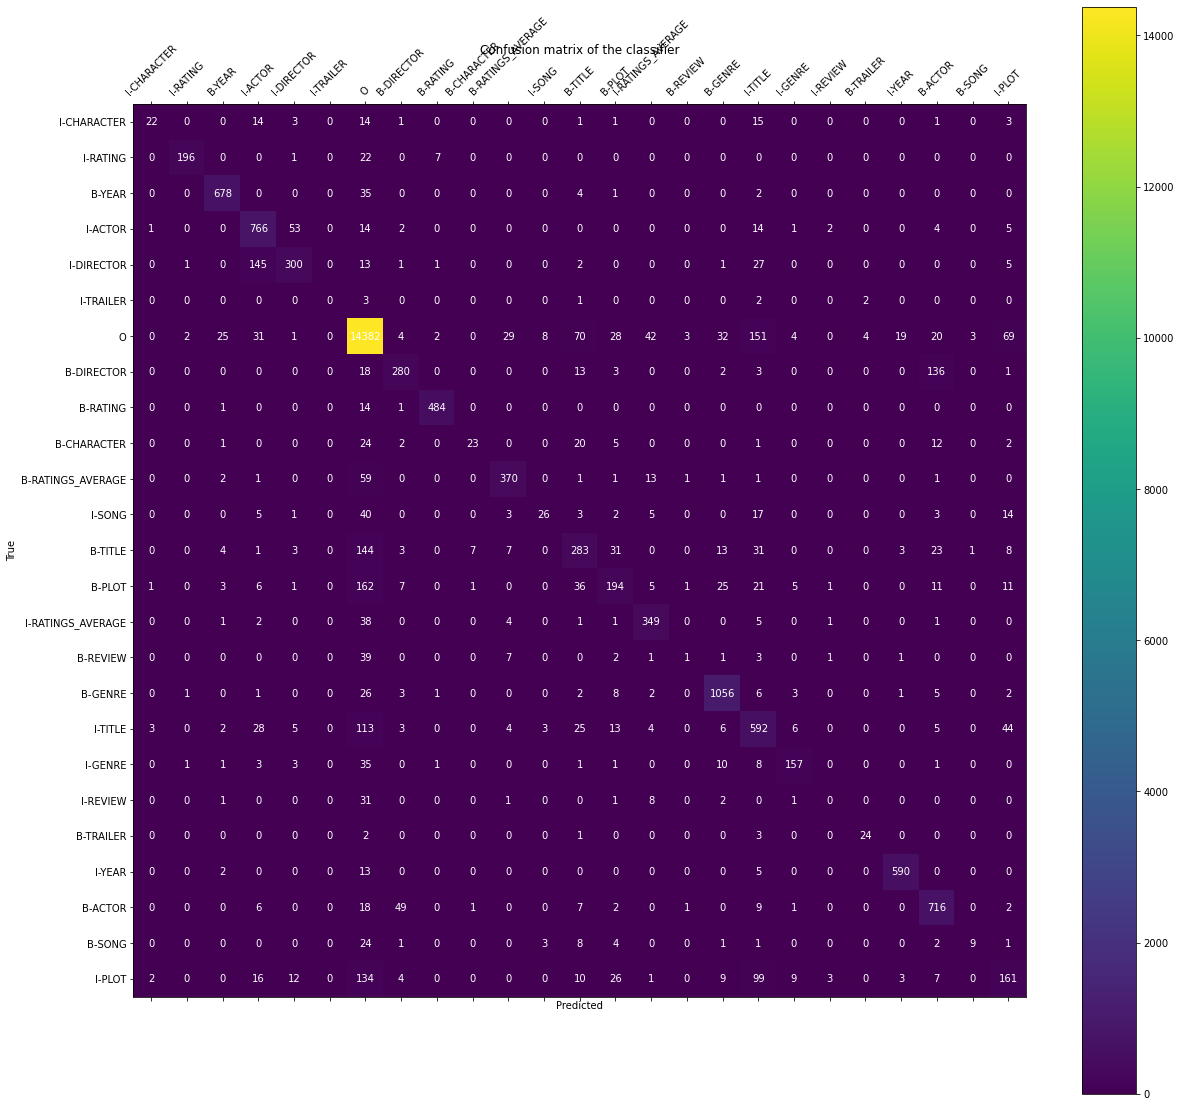

In [55]:
confusion_matrix_heatmap(y_test, preds)